# LGBM Plan

Important to Note
1. Null Values (plan is to for now, just ignore. focus on this once we get the main trends down for non-na products)
2. Long-term predictions (we need to figure out how to feature engineer with cycles)

    7 years train, 3 years test

## Features

1. Cycles
    - yearly
    - weekly (day of week)
    - monthly
    - biyearly
    - automatically calculate cycles?

within a product/store/country combo

how to capture cyclic behavior?
- same doy 3+ / day before, week before, avg. of year
- same month 3+ years ago / other months same year
    - same but averaged over all available years
    - num of years

basic datetime features
- year, month, dow, dom, doy, woy, wom, quarter

## Modelling Plan

1. Concat test to train

2. Create features, train lgbm
    - 2010 to 2015 train
    - 2016 validation

3. Visualize predictions in 2017-2019 (test)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import lightgbm as lgb

In [2]:
DIRECTORY = './data/'
train = pd.read_csv(DIRECTORY + 'train.csv', parse_dates=['date']).drop(columns='id')
test = pd.read_csv(DIRECTORY + 'test.csv', parse_dates=['date']).drop(columns='id')

In [3]:
# Clean
train['num_sold'] = train.groupby(by=['product', 'country', 'store'])['num_sold'].ffill().bfill()
test['num_sold'] = 0
combined = pd.concat([train, test])

In [4]:
def date_features(df: pd.DataFrame):
    assert('date' in df.columns)
    df['year'] = df['date'].dt.year - df['date'].dt.year.min()
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.day_of_week
    df['day_of_year'] = df['date'].dt.day_of_year
    df['quarter'] = df['date'].dt.quarter
    df['week_of_year'] = df['date'].dt.day_of_year // 52
    df['month_of_2y'] = (df['year']*12 + df['month']) % 24
    return df

combined = date_features(combined)

In [5]:
def lag_ratios(df: pd.DataFrame, lag_numerator, rolling_numerator, \
               lag_denominator, rolling_denominator):
    
    # convert to timedelta
    numerator_name = f'lag{lag_numerator}_roll{rolling_numerator}'
    denominator_name = f'lag{lag_numerator}_roll{rolling_denominator}'
    lag_numerator = pd.to_timedelta(lag_numerator)
    rolling_numerator = pd.to_timedelta(rolling_numerator)
    lag_denominator = pd.to_timedelta(lag_denominator)
    rolling_denominator = pd.to_timedelta(rolling_denominator)

    # shift and merge num
    if numerator_name not in df.columns:
        numerator_df = df.set_index('date').groupby(by=['product', 'store', 'country'])['num_sold'] \
            .rolling(rolling_numerator).mean().to_frame(numerator_name).reset_index()
        numerator_df['date'] = numerator_df['date'] + lag_numerator
        df = df.merge(numerator_df, on=['date', 'product', 'store', 'country'], how='left')

    # shift and merge den
    if denominator_name not in df.columns:
        denominator_df = df.set_index('date').groupby(by=['product', 'store', 'country'])['num_sold']\
            .rolling(rolling_denominator).mean().to_frame(denominator_name).reset_index()
        denominator_df['date'] = denominator_df['date'] + lag_denominator
        df = df.merge(denominator_df, on=['date', 'product', 'store', 'country'], how='left')

    df[f'ratio({numerator_name}/{denominator_name})'] = df[numerator_name] / df[denominator_name]
    return df

for yearLag in ['1096D', '1461D', '1826D']:
    for rollingDenominator in ['7D', '30D', '365D', '60D']:
        combined = lag_ratios(combined, yearLag, '1D', yearLag, rollingDenominator)


# Modelling with LGBM

In [6]:
def compress_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Factorize object
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')

    # Downcast numeric
    for col in df.select_dtypes(include=['int', 'float']).columns:
        col_type = df[col].dtype
        if col_type == 'int' or col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif col_type == 'float' or col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    
    # Optimize object columns
    return df

final_df = compress_dataframe(combined)

In [10]:
params = {
    'objective': 'regression',
    'metric': 'rmse',  # You can replace this with 'mae' or other metrics
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1
}

callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=True),
    lgb.log_evaluation(period=100)
]

In [22]:
train_boundary = pd.to_datetime('2016-01-01')
validation_boundary = pd.to_datetime('2017-01-01')

train_df = final_df[final_df.date < train_boundary]
val_df = final_df[(final_df.date >= train_boundary) & (final_df.date < validation_boundary)]
test_df = final_df[final_df.date >= validation_boundary]

models = []
predictions = []

for product in final_df['product'].unique():
    temp_train = train_df[train_df['product'] == product]
    train_set = lgb.Dataset(temp_train.drop(columns=['num_sold', 'date']), temp_train['num_sold'])

    temp_val = val_df[val_df['product'] == product]
    val_set = lgb.Dataset(temp_val.drop(columns=['num_sold', 'date']), temp_val['num_sold'])

    temp_test = test_df[test_df['product'] == product]
    test_X = temp_test.drop(columns=['num_sold', 'date'])

    model = lgb.train(
        params,
        train_set,
        valid_sets=[train_set, val_set],
        valid_names=['train', 'validation'],
        num_boost_round=1000,
        callbacks=callbacks
    )
    models.append(model)

    val_predictions = temp_val.drop(columns=['num_sold'])
    val_predictions['prediction'] = model.predict(temp_val.drop(columns=['num_sold', 'date']))

    test_predictions = temp_test.drop(columns=['num_sold'])
    test_predictions['prediction'] = model.predict(test_X)

    predictions_df = pd.concat([val_predictions, test_predictions])
    predictions.append(predictions_df)

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 91.0879	validation's rmse: 52.4127
[200]	train's rmse: 46.2651	validation's rmse: 29.3197
[300]	train's rmse: 28.5997	validation's rmse: 28.6771
Early stopping, best iteration is:
[267]	train's rmse: 32.3071	validation's rmse: 28.2004
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 389.198	validation's rmse: 277.565
[200]	train's rmse: 192.612	validation's rmse: 188.199
[300]	train's rmse: 123.958	validation's rmse: 184.544
Early stopping, best iteration is:
[256]	train's rmse: 143.81	validation's rmse: 184.149
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 323.773	validation's rmse: 235.061
[200]	train's rmse: 162.831	validation's rmse: 142.735
[300]	train's rmse: 105.605	validation's rmse: 134.601
Early stopping, best iteration is:
[348]	train's rmse: 93.8684	validation's rmse: 134.276
Training until validation scores don't improve for 50

In [23]:
# Combine results
predictions_df = pd.concat(predictions)

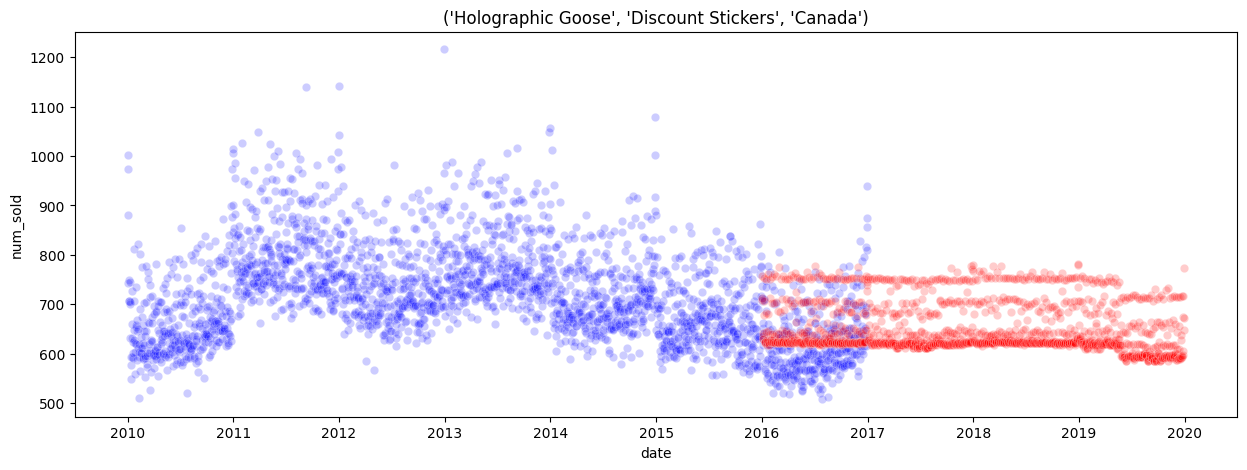

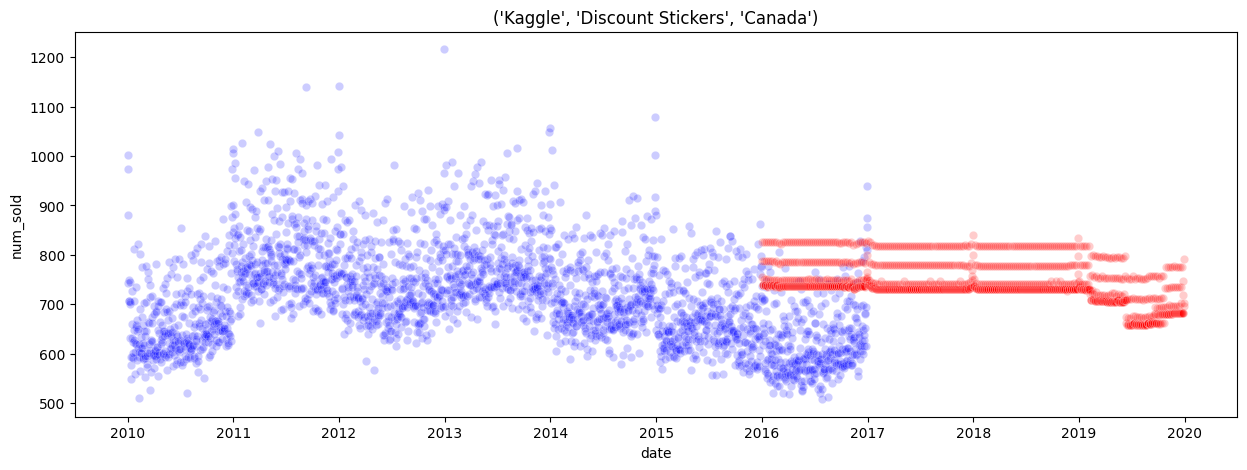

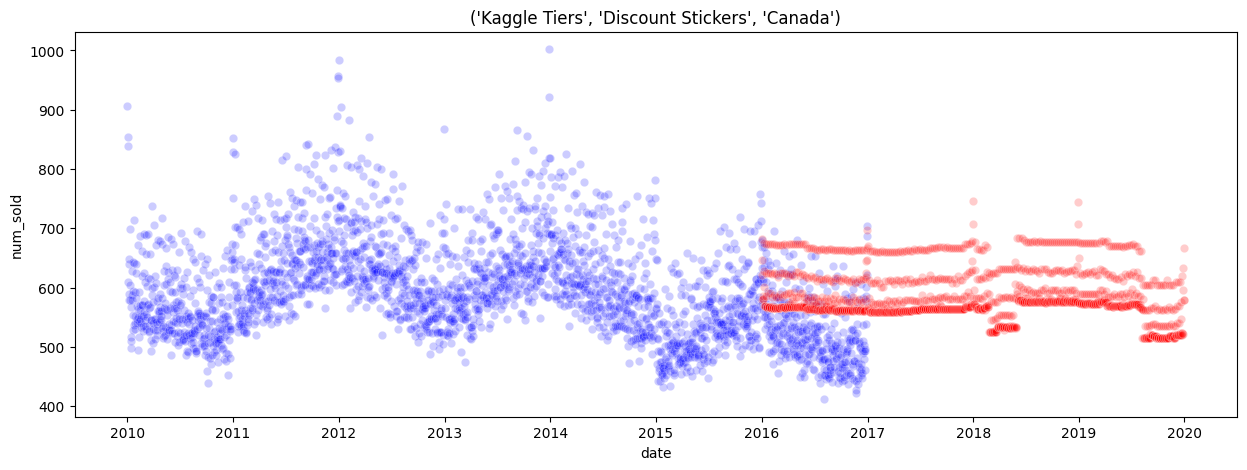

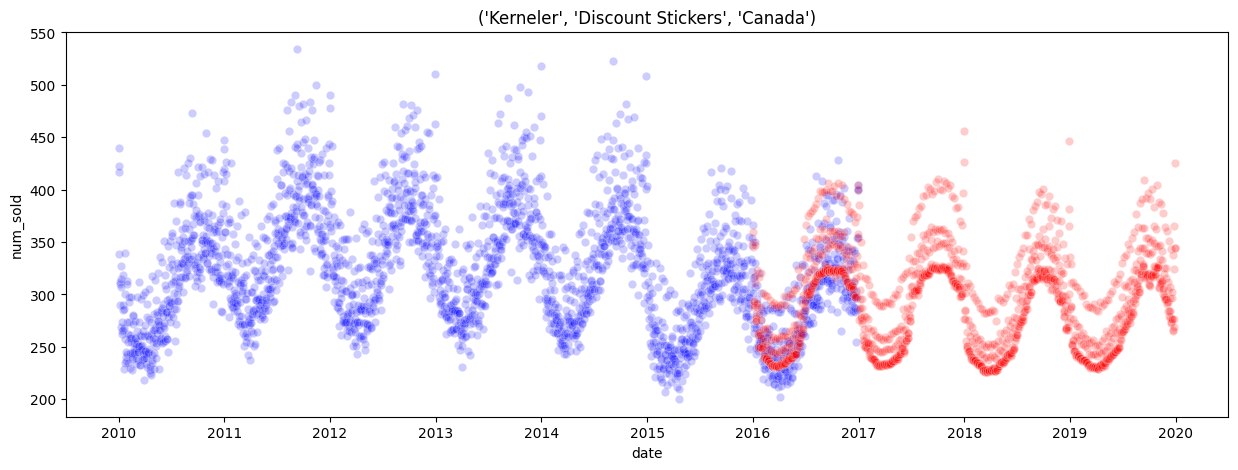

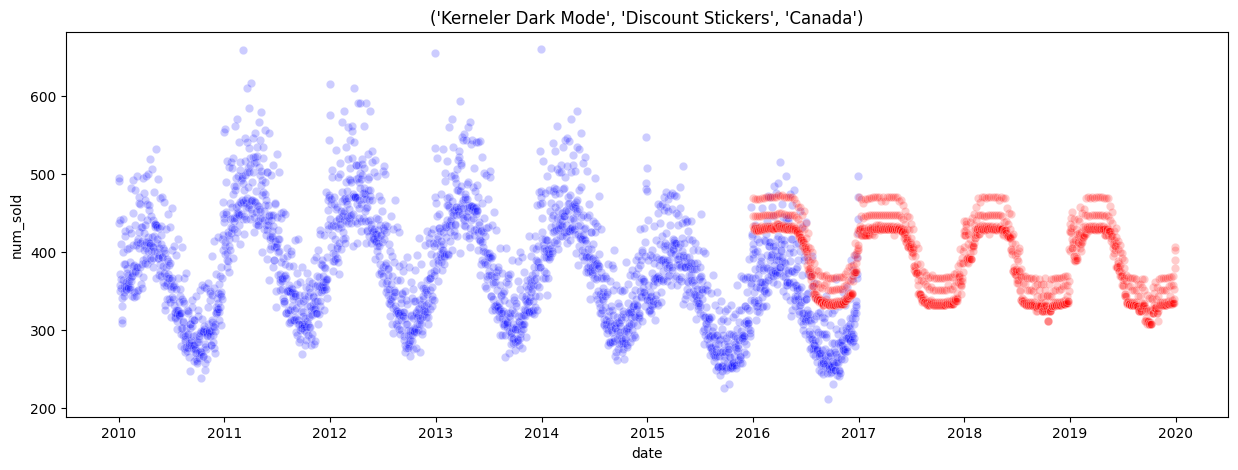

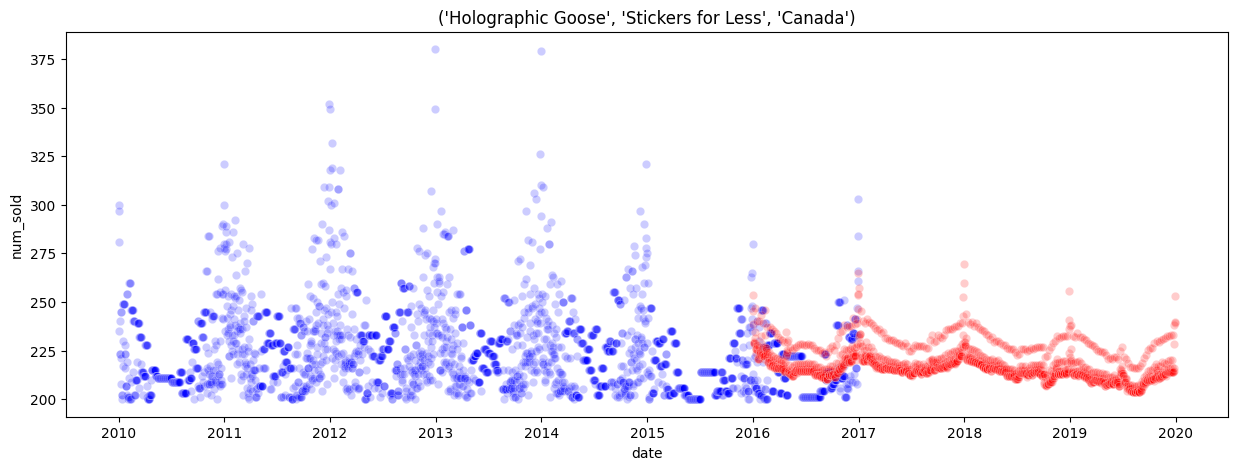

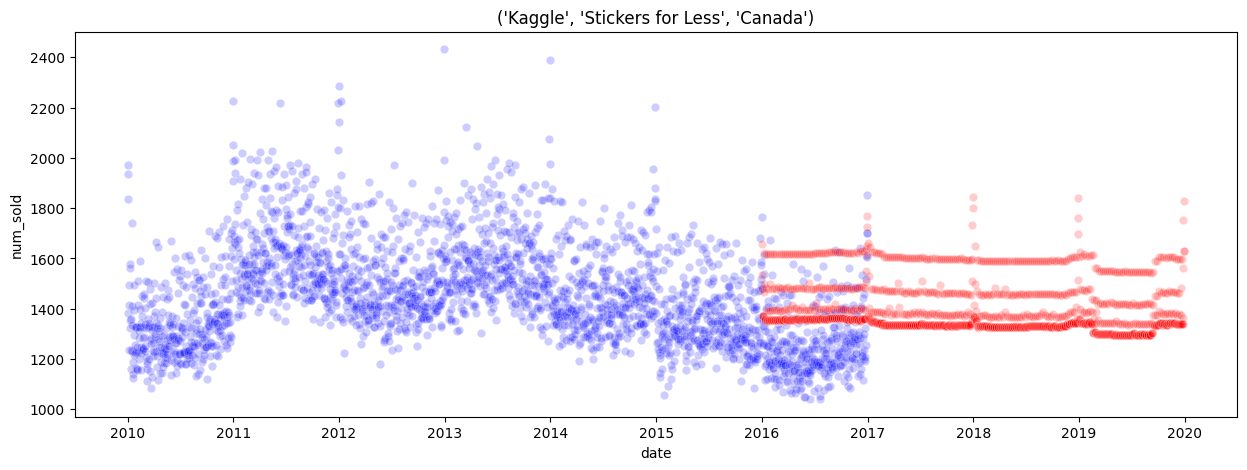

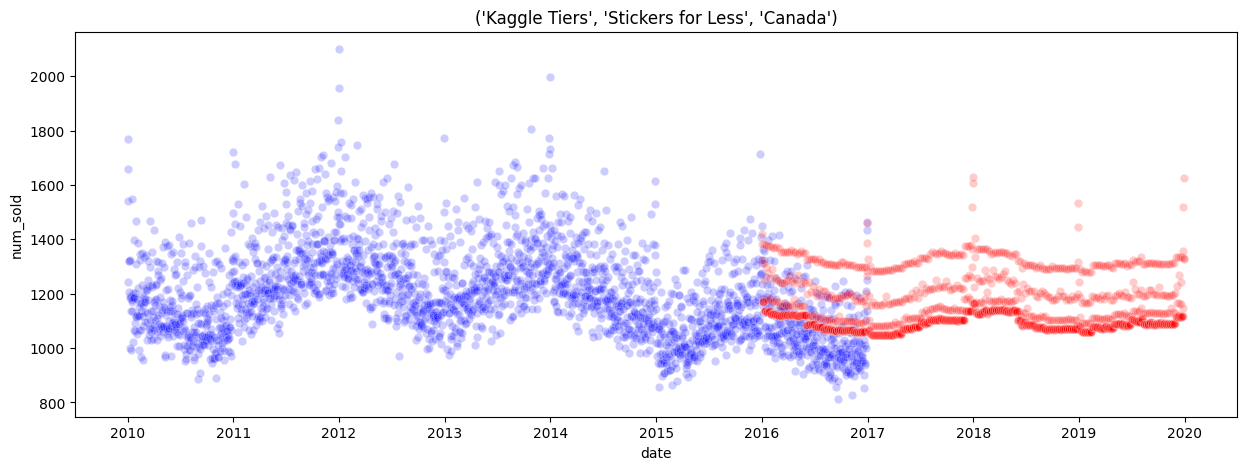

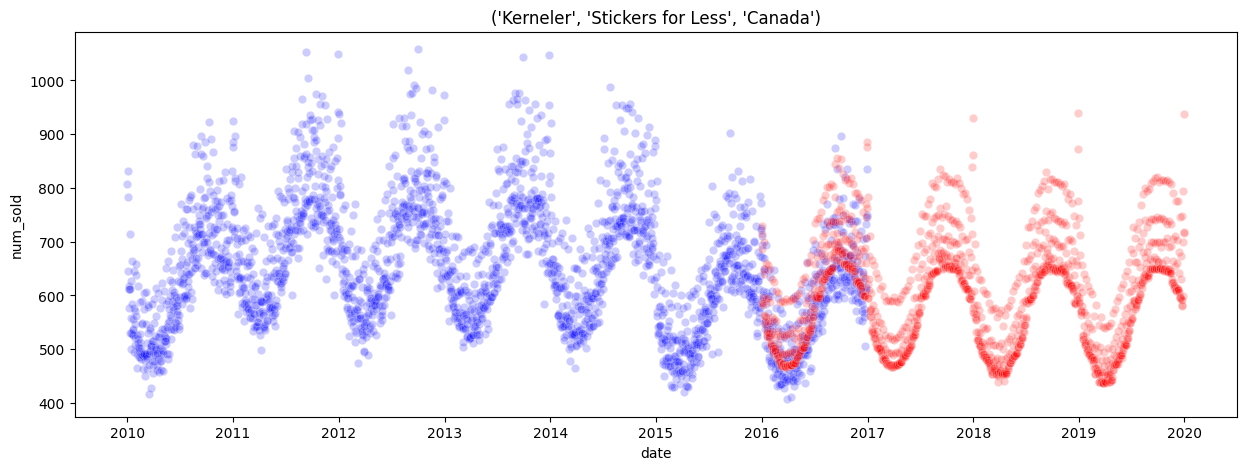

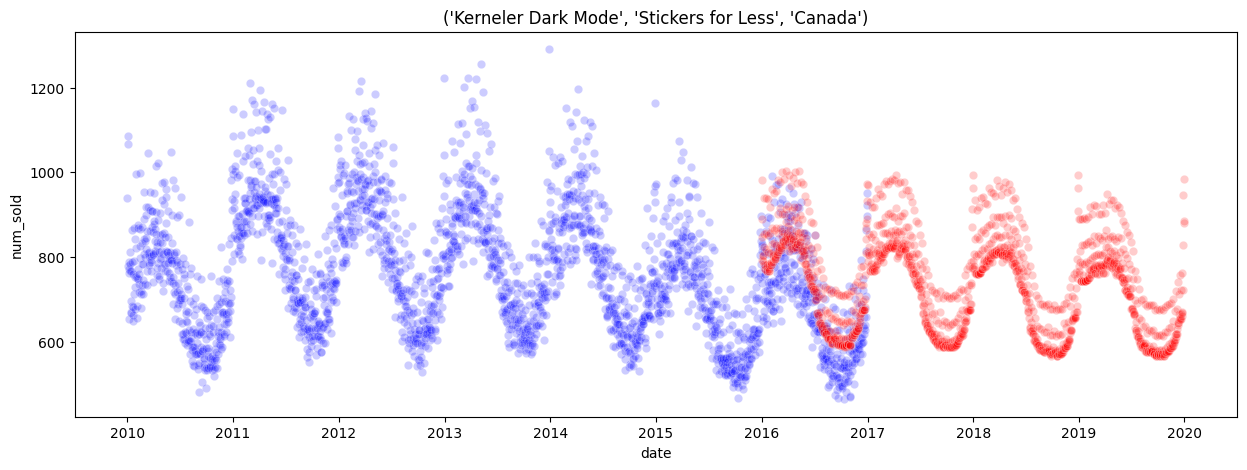

In [24]:
# Graph the results
index_cols = ['product', 'store', 'country']
combos = final_df[index_cols].drop_duplicates().set_index(index_cols).index

for combo in combos[:10]:
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=final_df[final_df.date < validation_boundary].set_index(index_cols).sort_index().loc[combo], \
                    x='date', y='num_sold', alpha=0.2, color='blue')
    sns.scatterplot(data=predictions_df.set_index(index_cols).sort_index().loc[combo], x='date', y='prediction', alpha=0.2, color='red')
    plt.title(combo)
    plt.show()

In [138]:
test = pd.read_csv(DIRECTORY + 'test.csv', parse_dates=['date'])
test.merge(right=test_df, on=['date', 'country', 'store', 'product'])[['id', 'prediction']].to_csv('first_submission.csv', index=False)